## GA evoltion of synaptic weights for a generalized cerebellar model

Using a general network with anatomical properties of the cerebellar model and the OKN eye plant model, use a GA to tunned the weights of synaptic connections to match the prediction properties (initiation and terminnation) observed in VOR adaptation.

# Eye plant with direct and indirect paths

Model presented at Hirata et al. 2002 Annals of the New York Academy of Sciences. Inagaki at al 2007.

$$G^{visual}_{indirect}(s)=\frac{0.025s^2 + 1.25s + 0.552885}{0.20643s^2+1.3544s+0.6589}e^{-0.047s}$$
$$G^{visual}_{direct}(s)=\frac{1}{s + K}$$

In cannonical controlable form:
$$\dot{q}(t)=\begin{bmatrix}
-6.5407 & -3.1492\\ 
1 & 0
\end{bmatrix}
q(t) + \begin{bmatrix}
1\\ 
0
\end{bmatrix}u(t)$$

$$y(t)=\begin{bmatrix}
5.2640 & 2.2833
\end{bmatrix}q(t) + 0.1211u(t)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy import signal


def feval(funcName, *args):
    return eval(funcName)(*args)


def simulate(func, yinit, x_range, h, stim):
    '''
    This function/module performs the forward Euler method steps.
    '''
    m = len(yinit) # Number of ODEs
    n = int((x_range[-1] - x_range[0])/h) # Number of steps
    
    x = x_range[0] # Initializes variables x
    y = yinit # Initializes variables y
    step = 0
    
    xsol = np.empty(0) # Creates an empty container for x
    xsol = np.append(xsol, x) # Fills in the first x

    ysol = [] # Creates an empty container for y
    ysol.append(y) # Fills in the initial conditions
    
    rslip = 0.
    epos = []
    direct = 0.
    indirect = 0.
    
    for i in range(n):
        
        rslip = stim[step] - (direct + indirect) if stim[step] >=0. else 0.
        epos.append([direct, indirect, (direct + indirect)])
        
        yprime = feval(func, y, rslip) # Evaluates dy/dx
        
        for j in range(m):
            y[j] = y[j] + h*yprime[j] # Eq. (8.2)
       
        xsol = np.append(xsol, x) # Saves it in the container
        ysol.append(y) # Saves all new y's 
        
        q1, q2, q3 = y
        direct = 0.*5.264*q1 + 0.*2.2833*q2 + 0.9*rslip
        indirect = q3
        
        x += h # Increase x-step
        step += 1
            
    return [xsol, ysol, epos]


def eye_plant(y, u):
    q1, q2, q3 = y
    dq1 = -6.5407*q1 - 3.1492*q2 + u
    dq2 =  q1
    dq3 = -0.1*q3 + u
    return [dq1, dq2, dq3]


dt = 0.01
xrange = np.array([0., 32.])
t = np.linspace(xrange[0],xrange[1],xrange[1]/dt, endpoint=False)
stim =10.*signal.square(2. * np.pi * 0.0625 * t, duty=0.5)+ 10.
yinit = np.array([0.,0.,0.]) 

q = simulate('eye_plant', yinit, xrange, dt, stim)


C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


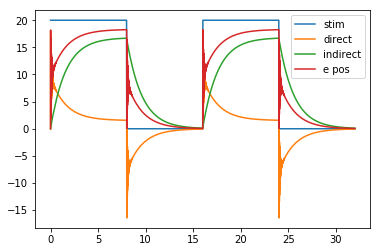

In [2]:
plt.plot(t, stim)

positions = np.array(q[2])
plt.plot(t, positions)
plt.legend(['stim','direct', 'indirect','e pos'])

## Implement AER for the network

In [106]:
noPre = [0, 3, 3, 3, 0, 0]
preIds = [0, 2, 3, 1, 4, 3, 1, 2, 5]
currents = [0.1, 0.0, 0.0, 0.0, 0.1, 0.1]
stim =signal.square(2. * np.pi * 0.1 * t, duty=0.5)


def activation(x):
    return np.tanh(x)


def propagate(w):
    offset = 0
    for i, n in enumerate(noPre):
        if n is 0:
            continue
        out = 0.
        
        for index in range(offset, offset+n):
            
            out += currents[preIds[index]]*w[index]

        currents[i] = activation(out + currents[i])
        offset += n

def evalNetwork(weights, plot=False):
#     weights = [w01, w11, w12, w21, w22]
    
    vn = []
    for x in t:
        propagate(weights)
        vn.append(currents[1])
        
#     Spectrum in frequency     
    signal_spectrum = np.fft.fftshift(np.fft.fft(vn, 10*len(vn)))
    freqs = np.fft.fftshift(np.fft.fftfreq(10*len(vn), d=dt))

    idx = np.argmax(np.abs(signal_spectrum[16000:]))

    idx = np.argmax(np.abs(signal_spectrum[16000:]))
    fitness = 1/freqs[idx+16000] if freqs[idx+16000] >0.05 else -100.
    
    pos = [x for x in vn if x>0]
    neg = [abs(x) for x in vn if x<0]
    dutty = np.sum(pos)/np.sum(neg)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(freqs[16001:], np.abs(signal_spectrum[16001:]))  
        plt.plot(freqs[idx+16000],np.abs(signal_spectrum[16000+idx]),'ro')
        plt.xlim(0, 2)
        plt.grid()

        plt.figure(figsize=(10,5))
        plt.plot(t,stim)
        plt.plot(t,vn)
        
        print('Frequency of CPG {} Hz, fitness {}'.format(freqs[idx+16000], fitness))
    return fitness*dutty,

In [ ]:
evalNetwork([0.0482, 0.77355, 0.591653, -0.49241, 0.891141])

In [102]:
import random

from deap import base
from deap import creator
from deap import tools

def generator_weights():
#     This generator is specific for a 2 neuron CPG where the inter
#     neuronal synapses are inhibitory
    return 2*np.random.random() - 1


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator 
toolbox.register("attr_val", generator_weights)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_val, len(preIds))

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalNetwork)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)


C:\Users\ruben\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\ruben\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [103]:
def checkpop():
#     This function forces inter neurons weights to be ihn
    for ind in pop:
        if ind[2] > 0: ind[2] *= -1 
        if ind[3] > 0: ind[3] *= -1 

random.seed(64)

# create an initial population of 300 individuals (where
# each individual is a list of integers)
pop = toolbox.population(n=300)
# checkpop()

# CXPB  is the probability with which two individuals
#       are crossed
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

print("Start of evolution")
# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    
print("  Evaluated %i individuals" % len(pop))
# Extracting all the fitnesses of 
fits = [ind.fitness.values[0] for ind in pop]

Start of evolution


C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


  Evaluated 300 individuals


In [104]:
# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 10 and g < 100:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring
#     checkpop()

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 1 --


C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


  Evaluated 154 individuals
  Min -inf
  Max 0.6233097294962714
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [-0.7451303584359115, 0.26410460904258404, 0.9995582262194709, 0.24051429848826356, -0.3877102677744577, 0.6417766702513377, -0.07411960486779634, 0.0, 0.0], (0.6233097294962714,)
-- Generation 2 --


C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


  Evaluated 171 individuals
  Min -inf
  Max 2.419942415255184
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.419942415255184,)
-- Generation 3 --
  Evaluated 187 individuals
  Min -inf
  Max 2.419942415255184
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.419942415255184,)
-- Generation 4 --
  Evaluated 161 individuals
  Min -inf
  Max 2.419942415255184
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.1429265010833

  Evaluated 202 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 26 --
  Evaluated 172 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 27 --
  Evaluated 181 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.1429265010833078

  Evaluated 178 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 49 --
  Evaluated 197 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 50 --
  Evaluated 187 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.1429265010833078

  Evaluated 198 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 72 --
  Evaluated 191 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 73 --
  Evaluated 188 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.1429265010833078

  Evaluated 164 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 95 --
  Evaluated 186 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.14292650108330784, 0.41798469886919487, 0.16412021806438082, -0.6653918433031054], (2.47839844388956,)
-- Generation 96 --
  Evaluated 166 individuals
  Min -inf
  Max 2.47839844388956
  Avg -inf
  Std nan
-- End of (successful) evolution --
Best individual is [0.3740046702676054, -0.07041289760860492, -0.028997524857118373, -0.142310724708113, 0.2940604751668414, 0.1429265010833078

Frequency of CPG 1.3562500000000002 Hz, fitness 0.7373271889400921


(3.1127654364811708,)

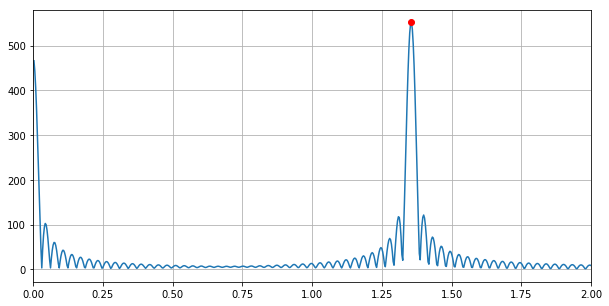

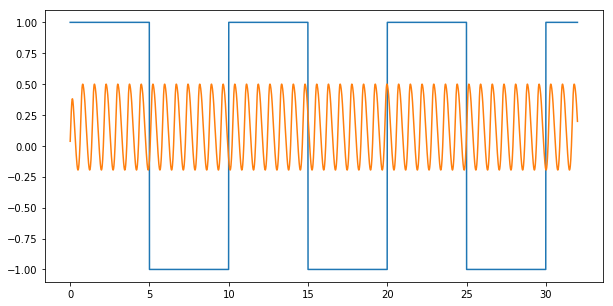

In [107]:
evalNetwork(best_ind, True)

Frequency of CPG 0.353125 Hz, fitness 2.831858407079646


(2.831858407079646,)

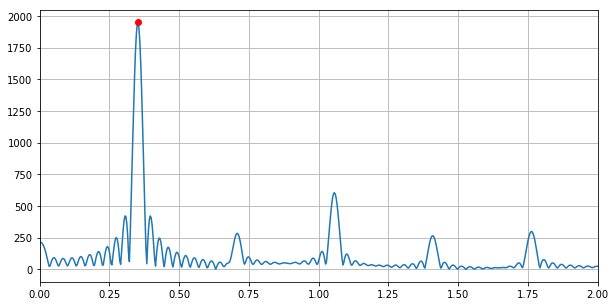

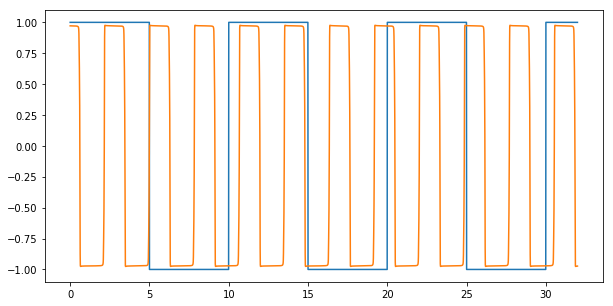

In [31]:
evalNetwork([0.0482, 0.77355, 0.581153, -0.47111, 0.891141], True)